<a href="https://colab.research.google.com/github/wajidhabib/dwmf-for-removal-of-random-valued-impulse-noise/blob/main/DWMF_for_Removal_of_Random_Valued_Impulse_Noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A New Directional Weighted Median Filter for Removal of Random-Valued Impulse Noise

PSNR value is 36.7492178956403 dB


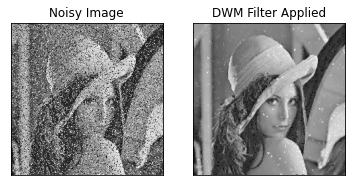

In [ ]:
"""
Wajid Ali (wajid.phdcs203@iiu.edu.pk)

Implementation of paper "A new directional weighted median filter for removal of random-valued impulse noise" 
by Yiqiu Dong and Shufang Xu

Steps:

1.  Take a gray scale image.
2.  Create a 5x5 filter window.
3.  Find the pixel values in 4 directions (vertical, horizontal, diagonal left, diagonal right) from the center pixel.
4.  Create a weight filter such that give double weight to the pixel which are neighbours of the center pixel.
5.  Calculate Absolute weighted difference of each pixel with center pixel value in each direction and take the minimum of them.
6.  Minimum value is compared to a threshold value; 
    
     if value > threshold; it is noisy pixel 
     else; it is not noisy pixel

7.  Calculate standard deviation of the 5 pixels in each direction
8.  Giving extra weight (say 2) to the direction in which the standard deviation is smallest,
9.  Compute the weighted median as V=alpha * yij  + (1-alpha)* median 
10. Replace the noisy pixel with this median value
11. Repeat the process (step 2-9) for 5-10 times for more smoother image.
12. Reduce Treshold value by .80 on each iteration.

"""

import cv2
import numpy as np
from matplotlib import pyplot as plt
import random
from google.colab.patches import cv2_imshow
 
from math import log10, sqrt

#variables
#Noise probability
P=float(0.1)

#Kernal Size (5x5)
K=5
padd = int((K-1)/2)

#Threshhold
T=510 #initial thershold

#No of iterations
Nmax=5

#1. Load Image (Gray Scale)

#gray_image = cv2.imread('/content/drive/MyDrive/ImageProcessing/images/Lenna.png',0)
img = cv2.imread('/content/drive/MyDrive/ImageProcessing/images/Lenna_gray.png')
#cv2_imshow(gray_image)
gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


def add_noise(image, prob):
    """This fuctions will add Salt and Pepper noise to given image.
    input parameters: Image and Probability of noise 

    Args:
        image (Image): Gray Scale image for adding noise
        prob (float): probablity of the noise less than 1 in float form like 0.3, 0.5 etc.

    Returns:
        Image: Image with added noise
    """
    
    output= np.zeros(image.shape,np.uint8)
    threshold = 1 - prob
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rnd=random.random()
            if rnd <prob:
                output[i][j]=0
            elif rnd>threshold:
                output[i][j] = 255
            else:
                output[i][j]=image[i][j]
    
    return output


def padd_zeros(img, kernal_size):
    """This fuction will padd zeros on the four sides of the given array or image

    Args:
        img (Image): image(array matrix) to padd zero with
        kernal_size (int): Size of the window e.g 3 or 5 etc.

    Returns:
        Image: Output imge with padded zeros.
    """
    
    kernal=np.ones((kernal_size,kernal_size),np.float32)/(kernal_size*kernal_size)    
    #size of the image
    SS=img.shape
    #size of kernal
    KS=kernal.shape

    rows=SS[0] + (KS[0]-1)
    cols=SS[1] + (KS[1]-1)

    padded_img=np.zeros((rows,cols))
 
    for i in range(SS[0]):
        for j in range(SS[1]):
            x=i+np.int32((KS[0]-1)/2)         
            y=j+np.int32((KS[1]-1)/2)
            padded_img[x,y]= img[i,j].astype(int)
  
    return padded_img    


def detect_impulse_in_window(window):
    """
    this function will detect the impulse in the window.

    [(1,1) (1,2) (1,3) (1,4) (1,5)
     (2,1) (2,2) (2,3) (2,4) (2,5)
     (3,1) (3,2) (3,3) (3,4) (3,5)
     (4,1) (4,2) (4,3) (4,4) (4,5)
     (5,1) (5,2) (5,3) (5,4) (5,5)  
    ]
    S1=(1,1),(2,2),(3,3),(4,4),(5,5)
    S2=(5,1),(4,2),(3,3),(2,4),(1,5)
    S3=(3,1),(3,2),(3,3),(3,4),(3,5)
    S4=(1,3),(2,3),(3,3),(4,3),(5,3)

    Args:
        window (image): window of size 5x5

     Returns:
        r: Minimum (smallest) value of all directional absolute differences.
        m: Weighted Median Value    
    """
     
    #print(window)
    #5x5 window 0-4
    S1= np.array([window[0][0],window[1][1],window[2][2],window[3][3],window[4][4]])
    S2= np.array([window[4][0],window[3][1],window[2][2],window[1][3],window[0][4]])
    S3= np.array([window[2][0],window[2][1],window[2][2],window[2][3],window[2][4]])
    S4= np.array([window[0][2],window[1][2],window[2][2],window[3][2],window[4][2]])
    
    #Center value
    S0=window[2][2]
     
    #divide each value in each directional array with S0 i.e center value in 5x5 window
    """
    S1=np.divide(S1,S0)
    S2=np.divide(S2,S0)
    S3=np.divide(S3,S0)
    S4=np.divide(S4,S0)
    """
     
    
    #S0 = S0/S0 #?? have to divide center value as well or not
         
    # make a weight window such that direct neigbours has double weight 
    weight_window= np.array([[1,1,1,1,1], [1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1],[1,1,1,1,1]])
    
    #print(f' w-window \n {weight_window}')
    
    W1= np.array([weight_window[0][0],weight_window[1][1],weight_window[2][2],weight_window[3][3],weight_window[4][4]])
    W2= np.array([weight_window[4][0],weight_window[3][1],weight_window[2][2],weight_window[1][3],weight_window[0][4]])
    W3= np.array([weight_window[2][0],weight_window[2][1],weight_window[2][2],weight_window[2][3],weight_window[2][4]])
    W4= np.array([weight_window[0][2],weight_window[1][2],weight_window[2][2],weight_window[3][2],weight_window[4][2]])
    
    
    S=np.array([S1,S2,S3,S4])
    W=np.array([W1,W2,W3,W4])

    #Subtract center value from each directional value before weighted sum  
    D1=sum(W1*abs(np.subtract(S1,S0)))
    D2=sum(W2* abs(np.subtract(S2,S0)))
    D3=sum(W3*abs(np.subtract(S3,S0)))
    D4=sum(W4*abs(np.subtract(S4,S0))) 
     
       
    """print("Directional indices:")
    print(f'D1= {D1}')
    print(f'D2= {D2}')
    print(f'D3= {D3}')
    print(f'D4= {D4}') 
   """
    #distances array
    D=np.array([D1,D2,D3,D4])

    #minimum of weighted directional values 
    min_D=np.min(D) 
 
    ##find standard deviation of pixels in each direction
    SD=np.std(S,1) #s.d along each row
      
    ##get minimum standar deviation       
    Min_SD=min(SD)
    
    #find the row in which standard deviation is minimum    
    min_index_sd= np.argmin(SD,axis=0)
     
    
    ##give weight to the direction in which minimum standard deviation
    WSD=S[min_index_sd]*2
    S[min_index_sd]=WSD
    
    median= np.median(S)    
    r=min_D   
    
    return r, median
    
  

def DWM_Filter(img, T):
    
    #3. Padd image with zeros
    padd_image=padd_zeros(img,K)
    
    rows=padd_image.shape[0]
    cols=padd_image.shape[1] 
    r=np.zeros(img.shape,np.uint8) 
    
    for i  in range(padd, rows-padd):
        for j in range(padd,cols-padd):
            
            Window = padd_image[i-(padd):i+(padd+1),j-(padd):j+(padd+1)] 
            y=padd_image[i][j]                        
             
            #get rmin and median
            rmin,m  = detect_impulse_in_window(Window)
                        
            #if rmin > Threshold assign o otherwise 1
            if(rmin>T):
                alpha=0
                #print('yes')
            else:
                alpha=1

            #weighted median (wm)
            dwm=alpha * np.double(y)  + (1-alpha)* m 
             
            #replace the noisy pixel with wm  
            
            r[i-padd][j-padd]=np.uint8(dwm)                        
    
    return r


percents=[20,30,40,50,60]

#2. Add Noise (Salt & Pepper)
noisy_image=add_noise(gray_image,P)

output_img = noisy_image

#3. Apply Detect and Apply Filter Nmx times

for i in range(Nmax):
    output = DWM_Filter(output_img,T)      
    output_img = np.uint8(output)
    T=T*0.8 

#cv2_imshow(noisy_image)
#cv2_imshow(output_img)

plt.subplot(121),plt.imshow(noisy_image,cmap='gray'),plt.title('Noisy Image')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(output_img,cmap='gray'),plt.title('DWM Filter Applied')
plt.xticks([]), plt.yticks([])

def psnr(orginal, denoised):
    mse = np.mean( (orginal - denoised) ** 2 )
    if mse == 0:
      return 100
    PIXEL_MAX = 255.0
    return 20 * log10(PIXEL_MAX / sqrt(mse))
 
d=psnr(gray_image,output_img)
print(f"PSNR value is {d} dB")



    
        
        